## Evaluation System 1

[Info] Using device: cpu | n=5000, d=1000, p=2
[Info] Spectral matrix L shape: torch.Size([10000, 10000])


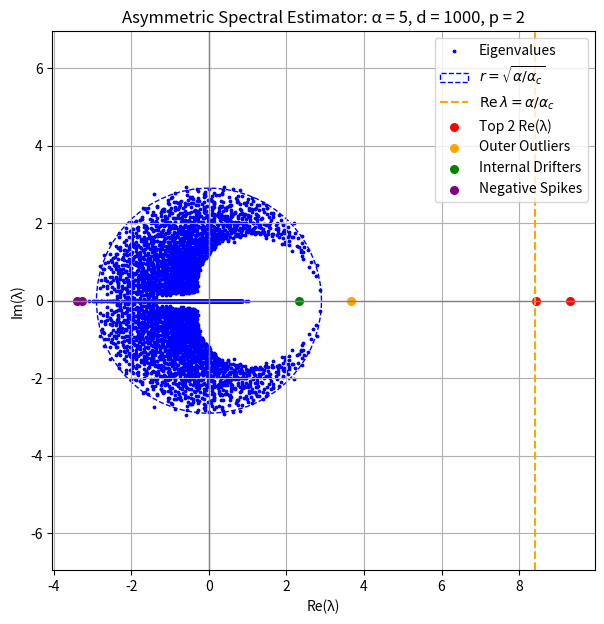

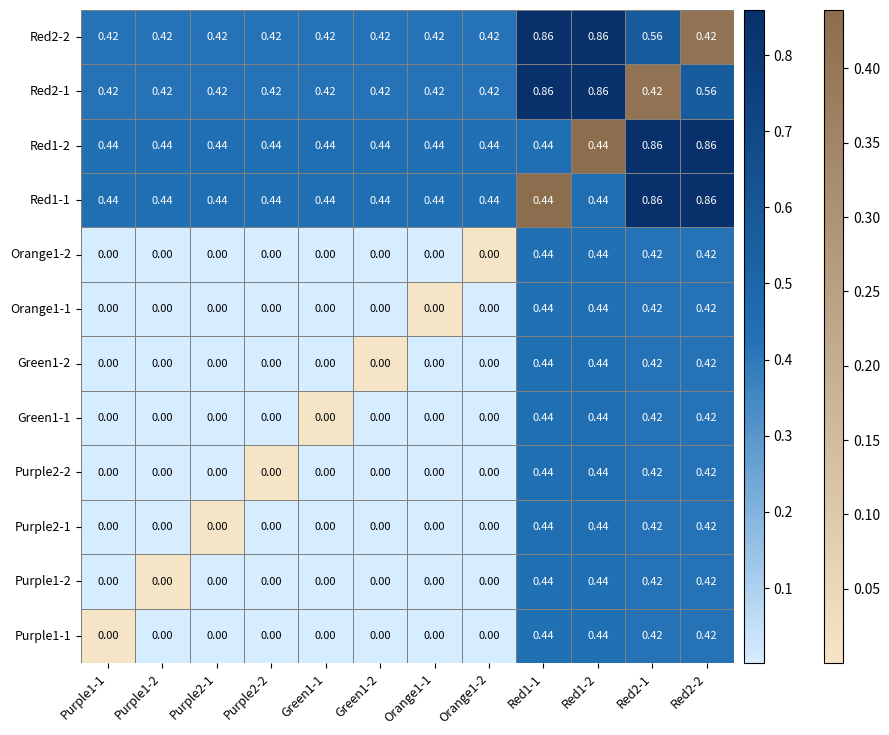


=== Rank-1 Overlap Summary ===
        Label  Overlap_q
0      Red1-2   0.439460
1      Red1-1   0.439460
2      Red2-2   0.420235
3      Red2-1   0.420235
4    Green1-1   0.001786
5    Green1-2   0.001786
6   Purple2-2   0.001431
7   Purple2-1   0.001431
8   Orange1-2   0.001128
9   Orange1-1   0.001127
10  Purple1-2   0.000015
11  Purple1-1   0.000015
Mean: 0.1440 | Max: 0.4395 | Min: 0.0000

=== Top-5 Rank-2 Overlap Combinations ===
        ComboLabel  Rank2_Overlap_q
0  Red1-1 + Red2-2         0.859771
1  Red1-2 + Red2-1         0.859771
2  Red1-2 + Red2-2         0.859771
3  Red1-1 + Red2-1         0.859771
4  Red2-2 + Red2-1         0.564716


In [6]:
import os, random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.linalg import qr
from scipy.special import kv as besselk
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# ---- Utilities ----
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda_manual_seed(seed)
        torch.cuda_manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

# 热力图修正
def get_text_color(value, cmap, vmin, vmax):
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

set_seed(42)

# Default lightweight config
n = 5000       
p = 2
alpha = 5
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device} | n={n}, d={d}, p={p}")

# ========================
# Step 1. Generate Data
# ========================
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device) #T
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2   

# ========================
# Step 2. Compute G(y)
# For demonstration purposes, we move data from GPU to CPU here.
# ========================
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1, K0 = besselk(1, abs_y), besselk(0, abs_y) # Bessel-based
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # NO NaN

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# ========================
# Step 3. Build ASE Spectral Matrix L
# ========================

# sample similarity matrix XXᵀ (n×n)
XXT = X @ X.T
XXT.fill_diagonal_(0.0) # Remove self-loops

# Prepare broadcasting shapes
A = XXT[:, :, None, None]        # (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :] # (1, n, p, p)

# Build block-wise spectral structure：L_ij = (XXᵀ)_ij × G(y_j)
L_blocks = A * G_broadcast       # (n, n, p, p)

# Rearrange dimensions and flatten to final L
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"[Info] Spectral matrix L shape: {L.shape}")

# ========================
# Step 4. Eigen Decomposition & Classification
# ========================
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real = eigvals_np[real_mask]

# Red, Orange, Green, Purple classification
red_vals = sorted(eigvals_real, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in eigvals_real if abs(z) > R and z.real > 0 and z not in red_vals]
green_vals = sorted([z for z in eigvals_real if abs(z) <= R and z.real > 0],
                    key=lambda z: z.real, reverse=True)[:1]
purple_vals = [z for z in eigvals_real if z.real < 0 and abs(z) > R][:2]

# ========================
# Step 5. Overlap Computation
# ========================
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic') # orthogonalization - thin QR
    X_cpu = X.cpu().numpy().T
    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)
        U = X_cpu @ V
        for j in range(2):
            u = U[:, j]
            u_hat = u / np.linalg.norm(u)
            q = np.linalg.norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

df_result = pd.DataFrame(
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, purple_vals, "Purple", X),
    columns=["Label", "Eigenvalue", "Overlap_q"]
).sort_values("Overlap_q", ascending=False).reset_index(drop=True)

def rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X):
    results = []
    W_orth, _ = qr(W_star_np, mode='economic')
    X_cpu = X.cpu().numpy().T
    v_map = {}
    for row in df_result.itertuples():
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx].reshape(-1, 2)
        j = 0 if '1' in label[-3:] else 1
        v_map[label] = v_hat[:, j]
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])
        U, _ = qr(U, mode='economic')
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2
        results.append((f"{id1} + {id2}", q))
    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False).reset_index(drop=True)

df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)

# ========================
# Step 6. Visualization 
# ========================

# --- (1) Eigenvalue spectrum ---
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=30, label="Internal Drifters")
plt.scatter([z.real for z in purple_vals], [z.imag for z in purple_vals], color="purple", s=30, label="Negative Spikes")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# --- (2) Heatmap ---
labels_rank1 = set(df_result["Label"])
labels_rank2 = set()
for combo in df_rank2["ComboLabel"]:
    a, b = combo.split(" + ")
    labels_rank2.update([a, b])
all_labels = sorted(labels_rank1.union(labels_rank2))
color_order = ["Purple", "Green", "Orange", "Red"]
sorted_labels = []
for color in color_order:
    sorted_labels.extend(sorted([l for l in all_labels if color.lower() in l.lower()]))

heatmap_matrix = pd.DataFrame(np.nan, index=sorted_labels, columns=sorted_labels)
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']
for _, row in df_result.iterrows():
    heatmap_matrix.loc[row['Label'], row['Label']] = row['Overlap_q']

cmap_rank2 = LinearSegmentedColormap.from_list("blue_grad", ["#D6ECFF", "#2171B5", "#08306B"])
cmap_rank1 = LinearSegmentedColormap.from_list("brown_grad", ["#F5E5C6", "#8C6D4E"])
rank1_vals = heatmap_matrix.values[np.eye(len(sorted_labels), dtype=bool)]
rank2_vals = heatmap_matrix.values[~np.eye(len(sorted_labels), dtype=bool)]
rank1_min, rank1_max = np.nanmin(rank1_vals), np.nanmax(rank1_vals)
rank2_min, rank2_max = np.nanmin(rank2_vals), np.nanmax(rank2_vals)

fig, ax = plt.subplots(figsize=(9, 8))
mask_rank1 = ~np.eye(len(sorted_labels), dtype=bool)
mask_rank2 = np.eye(len(sorted_labels), dtype=bool)

sns.heatmap(heatmap_matrix, mask=mask_rank2, cmap=cmap_rank2, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)
sns.heatmap(heatmap_matrix, mask=mask_rank1, cmap=cmap_rank1, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)

for i in range(len(sorted_labels)):
    for j in range(len(sorted_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value): continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", ha='center', va='center', color=color, fontsize=8)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)
fig.colorbar(ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max)), cax=cax1)
fig.colorbar(ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max)), cax=cax2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# ========================
# Step 7. Summary
# ========================
print("\n=== Rank-1 Overlap Summary ===")
print(df_result[["Label", "Overlap_q"]])
print(f"Mean: {df_result['Overlap_q'].mean():.4f} | "
      f"Max: {df_result['Overlap_q'].max():.4f} | "
      f"Min: {df_result['Overlap_q'].min():.4f}")

print("\n=== Top-5 Rank-2 Overlap Combinations ===")
print(df_rank2.head(5))


## Evaluation System 2

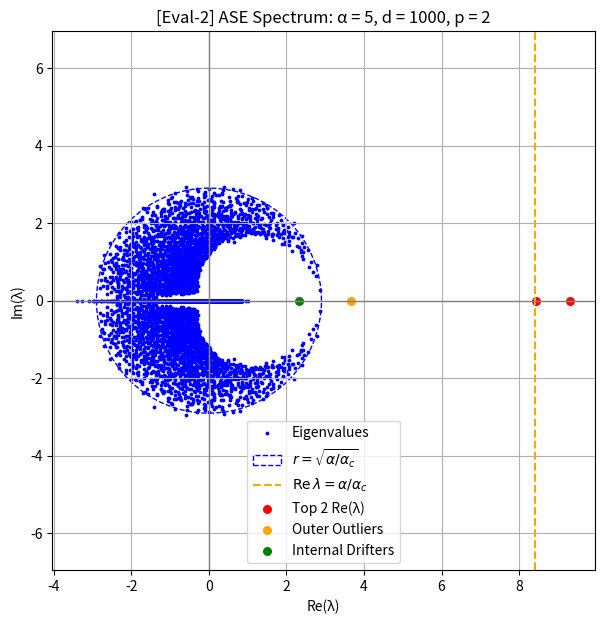


=== [Eval-2] Alignment Score — Individual Eigenvalues (Rank-1) ===
      Type                   λ  Alignment Score
2     Red1  9.318233+0.000000j         0.651093
3     Red2  8.425777+0.000000j         0.507414
0   Green1  2.314434+0.000000j         0.068145
1  Orange1  3.664519+0.000000j         0.055148

=== [Eval-2] Alignment Score — Eigenvalue Pairs (Rank-2) ===
             Pair                  λ1                  λ2  Alignment Score
5       Red1-Red2  9.318233+0.000000j  8.425777+0.000000j         0.651093
0  Green1-Orange1  2.314434+0.000000j  3.664519+0.000000j         0.068145
1     Green1-Red1  2.314434+0.000000j  9.318233+0.000000j         0.068145
2     Green1-Red2  2.314434+0.000000j  8.425777+0.000000j         0.068145
3    Orange1-Red1  3.664519+0.000000j  9.318233+0.000000j         0.055148
4    Orange1-Red2  3.664519+0.000000j  8.425777+0.000000j         0.055148


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_31672/3754622435.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


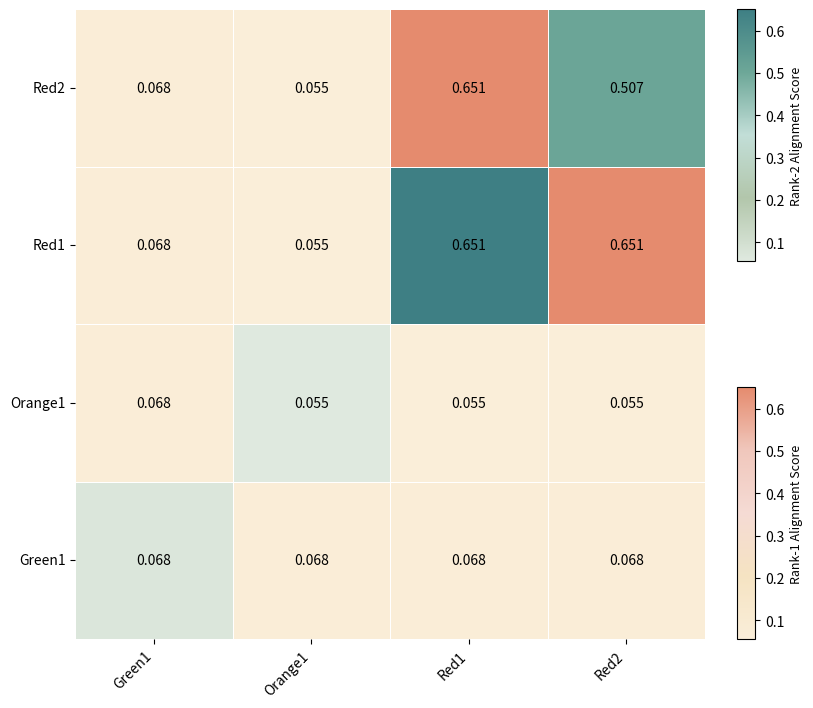

In [16]:

import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# eigendecomposition
try:
    eigvals_np, eigvecs_np  # type: ignore
except NameError:
    eigvals, eigvecs = torch.linalg.eig(L)
    eigvals_np = eigvals.detach().cpu().numpy()
    eigvecs_np = eigvecs.detach().cpu().numpy()

# Calculate the alignment degree (average singular value) of the two subspaces
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction of individual eigenvalues + alignment degree:
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)                   # (n, p)
    U = (X.cpu().numpy().T) @ V                # (d, p)
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Extraction of subspaces of two eigenvalues + Alignment degree (Rank-2 scenario)
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)                     # (n, p)
    V2 = v2.reshape(-1, p)                     # (n, p)
    V = np.hstack([V1, V2])                    # (n, 2p) → (n,4)
    U = X.cpu().numpy().T @ V                  # (d, 2p)  (d,4)
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# ========================
# Parameters and Spectral Point Classification
# ========================

R = float(np.sqrt(alpha / alpha_c))            
thresh_ext = float(alpha / alpha_c)            
W_star_np = W_star.detach().cpu().numpy()

eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]

outside_radius = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside_radius, key=lambda z: z.real, reverse=True)[:2]

orange_vals = [z for z in outside_radius if z not in red_vals]

green_candidates = [z for z in eigvals_real_only if abs(z) <= R and z.real > 0]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:1]

green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals)]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(sorted(orange_vals, key=lambda z: z.real, reverse=True))]
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(sorted(red_vals, key=lambda z: z.real, reverse=True))]

# Label sequence（Green → Orange → Red）
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]

# --- Eigenvalue spectrum ---
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels],
            color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels],
            color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels],
            color="green", s=30, label="Internal Drifters")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)"); plt.ylabel("Im(λ)")
plt.title(f"[Eval-2] ASE Spectrum: α = {alpha}, d = {int(n/alpha)}, p = 2")
plt.legend(); plt.grid(True); plt.axis("equal"); plt.show()

# ---------- Rank-1 ----------
results_single = []
for label, z in all_labels:
    results_single.append(extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label))
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== [Eval-2] Alignment Score — Individual Eigenvalues (Rank-1) ===")
print(df_single.sort_values("Alignment Score", ascending=False))

# ---------- Rank-2 ----------
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(
        extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label)
    )
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== [Eval-2] Alignment Score — Eigenvalue Pairs (Rank-2) ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False).head(10))

# ---------- heatmap data (diagonal = Rank-1; off-diagonal = Rank-2) ----------
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)
for _, row in df_single.iterrows():  # diagonal cells
    heatmap_df.loc[row["Type"], row["Type"]] = row["Alignment Score"]
for _, row in df_pair.iterrows():    # off-diagonal cells
    l1, l2 = row["Pair"].split("-")
    heatmap_df.loc[l1, l2] = row["Alignment Score"]
    heatmap_df.loc[l2, l1] = row["Alignment Score"]


diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]   # Rank-1
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"] # Rank-2
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)

# masks
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)   # Diagonal = False → use diagonal colormap
mask_offdiag = ~mask_diag                   # Off-diagonal = False → use off-diagonal colormap

# unified value
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# ---------- heatmap (two overlays + dual colorbars) ----------
fig, ax = plt.subplots(figsize=(8, 7))

# Off-diagonal heatmap (Rank-2 alignment scores)
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1),
                      bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm1, cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

# Diagonal heatmap (Rank-1 alignment scores)
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1),
                      bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm2, cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)


for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()


## Evaluation System 3


[Method 3: Single Eigenvector Alignment Scores]
  Eigenvalue  Index  Alignment Score
0     Green1   1159         0.026850
1    Orange1     37         0.019658
2       Red1      0         0.474069
3       Red2      1         0.452928

[Method 4: Eigenvector Pair Alignment Scores]
             Pair         Eigenvalue1         Eigenvalue2  Alignment Score
5       Red1-Red2  9.318233+0.000000j  8.425777+0.000000j         0.655655
1     Green1-Red1  2.314434+0.000000j  9.318233+0.000000j         0.474915
3    Orange1-Red1  3.664519+0.000000j  9.318233+0.000000j         0.474248
2     Green1-Red2  2.314434+0.000000j  8.425777+0.000000j         0.453724
4    Orange1-Red2  3.664519+0.000000j  8.425777+0.000000j         0.453355
0  Green1-Orange1  2.314434+0.000000j  3.664519+0.000000j         0.031383


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_31672/1205365483.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


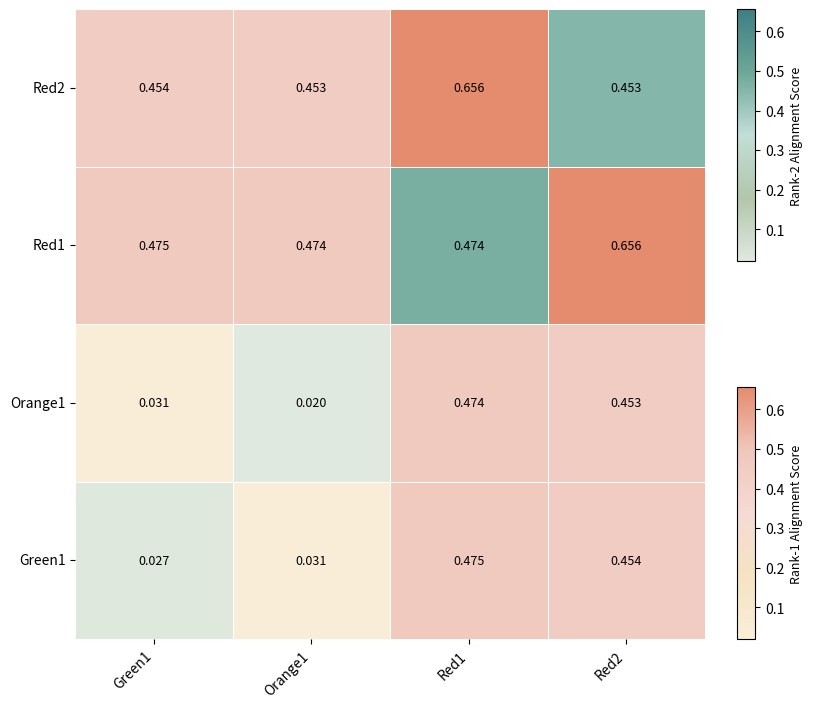

In [18]:
# ==================================================
# ASE Evaluation System (with Lifting)
# Methods 3 & 4 + Heatmap Visualization
# ==================================================
import numpy as np
import pandas as pd
from scipy.linalg import qr
from numpy.linalg import norm
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ----------------------------
# Step 1. Alignment Helper
# ----------------------------
def alignment_score(W_hat, W_star):
    """
    Compute subspace alignment score between estimated and true subspaces.
    Frobenius norm of overlap matrix normalized by subspace dimension p.
    """
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# ----------------------------
# Step 2. Single Eigenvector Evaluation (Method 3)
# ----------------------------
def map_multiple_eigvecs_to_2d(eigvecs_np, eigvals_np, selected_eigvals,
                               X, W_star, eigval_to_label, p=2):
    """
    Map each eigenvector into **2d lifted space** and compute alignment scores.

    LIFTING OCCURS HERE:
    ------------------------------------
    For each eigenvector v ∈ R^{np}, we:
        1) Reshape v → V ∈ R^{n×p}
        2) Map each column to d-dim via X^T @ V[:, i]
        3) **Vertically stack p columns** → mapped_vec ∈ R^{2d×1}
    Compare mapped_vec with lifted W_star_2d ∈ R^{2d×p}.
    """
    n, d = X.shape
    results = []

    # Ground-truth subspace lifted to 2d
    W_star_2d = np.vstack([W_star[:, i].reshape(-1, 1) for i in range(p)])  # (2d × p)

    for val in selected_eigvals:
        idx = np.argmin(np.abs(eigvals_np - val))
        v = eigvecs_np[:, idx]             # shape: (np,)
        V = v.reshape(n, p)               # shape: (n, p)

        # Map eigenvector into 2d lifted space
        v0 = X.T @ V[:, 0]                # d × 1
        v1 = X.T @ V[:, 1]                # d × 1
        mapped_vec = np.vstack([v0.reshape(-1,1), v1.reshape(-1,1)])  # **lifting to 2d**

        mapped_vec /= (norm(mapped_vec, axis=0, keepdims=True) + 1e-12)

        score = alignment_score(mapped_vec, W_star_2d)
        label = eigval_to_label.get(val, f"Unknown_{val}")
        results.append({"Eigenvalue": label, "Index": idx, "Alignment Score": score})

    return pd.DataFrame(results)

# ----------------------------
# Step 3. Eigenvector Pair Evaluation (Method 4)
# ----------------------------
def joint_map_and_align(eigvecs_np, eigvals_np, pairs, X, W_star, p=2):
    """
    Jointly map pairs of eigenvectors into **2d lifted space** and evaluate alignment.

    LIFTING OCCURS HERE:
    ------------------------------------
    For each pair (v1, v2):
        1) Reshape each v → V ∈ R^{n×p}
        2) Map each channel via X^T @ V[:, channel]
        3) **Vertically stack p channels** → W_hat ∈ R^{2d×2}
    Compare W_hat with lifted W_star_2d ∈ R^{2d×p}.
    """
    n, d = X.shape
    results = []

    # Ground-truth subspace lifted to 2d
    W_star_2d = np.vstack([W_star[:, i].reshape(-1, 1) for i in range(p)])  # (2d × p)

    for (label1, val1, label2, val2) in pairs:
        idx1 = np.argmin(np.abs(eigvals_np - val1))
        idx2 = np.argmin(np.abs(eigvals_np - val2))

        v1 = eigvecs_np[:, idx1].reshape(n, p)
        v2 = eigvecs_np[:, idx2].reshape(n, p)

        V_combined = np.stack([v1, v2], axis=2)  # shape: (n, p, 2)

        mapped_columns = []
        for pi in range(p):
            mapped_columns.append(X.T @ V_combined[:, pi, :])  # d × 2
        W_hat = np.vstack(mapped_columns)                      # **lifting to 2d**

        W_hat /= (norm(W_hat, axis=0, keepdims=True) + 1e-12)

        Q1, _ = qr(W_hat, mode='economic')
        Q2, _ = qr(W_star_2d, mode='economic')
        overlap = Q1.T @ Q2
        _, s, _ = np.linalg.svd(overlap)
        score = np.mean(s)

        results.append({
            "Pair": f"{label1}-{label2}",
            "Eigenvalue1": val1,
            "Eigenvalue2": val2,
            "Alignment Score": score
        })

    return pd.DataFrame(results)

# ----------------------------
# Step 4. Run Evaluation
# ----------------------------
eigval_to_label = {val: label for label, val in all_labels}
selected_eigvals = list(eigval_to_label.keys())

# Method 3: Single eigenvector alignment
df_single = map_multiple_eigvecs_to_2d(
    eigvecs_np, eigvals_np, selected_eigvals,
    X.cpu().numpy(), W_star.cpu().numpy(),
    eigval_to_label, p=2
)

# Method 4: Eigenvector pair alignment
all_pairs = list(combinations(all_labels, 2))
pairs = [(l1, v1, l2, v2) for (l1, v1), (l2, v2) in all_pairs]

df_pair = joint_map_and_align(
    eigvecs_np, eigvals_np, pairs,
    X.cpu().numpy(), W_star.cpu().numpy(), p=2
)

print("\n[Method 3: Single Eigenvector Alignment Scores]")
print(df_single)
print("\n[Method 4: Eigenvector Pair Alignment Scores]")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ----------------------------
# Step 5. Heatmap Visualization
# ----------------------------
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# Fill diagonals with Rank-1 scores
for _, row in df_single.iterrows():
    heatmap_df.loc[row["Eigenvalue"], row["Eigenvalue"]] = row["Alignment Score"]

# Fill off-diagonals with Rank-2 scores
for _, row in df_pair.iterrows():
    a, b = row["Pair"].split("-")
    heatmap_df.loc[a, b] = heatmap_df.loc[b, a] = row["Alignment Score"]

# Colormaps
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)

# Masks
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)

# Heatmap plotting
fig, ax = plt.subplots(figsize=(8, 7))
vmin, vmax = np.nanmin(heatmap_df.values), np.nanmax(heatmap_df.values)

# Rank-2 (off-diagonal)
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap,
            vmin=vmin, vmax=vmax, square=True,
            linewidths=0.5, cbar=False, ax=ax)
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1),
                      bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

# Rank-1 (diagonal)
sns.heatmap(heatmap_df, mask=~mask_diag, cmap=diag_cmap,
            vmin=vmin, vmax=vmax, square=True,
            linewidths=0.5, cbar=False, ax=ax)
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1),
                      bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)

# Annotate scores
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=9)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()
